## OpenDP Relative Risk - Trying out stuff in Python

Just a simple pipeline

In [1]:
import opendp.prelude as dp
dp.enable_features("contrib")

d_in = 1 # input distance
input_metric = dp.symmetric_distance()

d_out = 1 # epsilon
privacy_measure = dp.max_divergence(T=float) # pure dp

# We don't really use what's left below in this code box
######################################################################################

col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

import urllib.request
data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as data_req:
    data = data_req.read().decode('utf-8')

# Make a queriable
m_sc = dp.c.make_sequential_composition(
    # data set is a single string, with rows separated by linebreaks
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

qbl_sc = m_sc(data)

A transformation and two possible mechanisms

In [2]:
import opendp as dpf

# Make a query
count_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names)
    >> dp.t.make_select_column("age", str)
    >> dp.t.then_count()
)
count_sensitivity = count_transformation.map(d_in)

# Add a Laplace measurement
laplace_scale = 1.0
count_laplace_measurement = count_transformation >> dp.m.then_laplace(scale=laplace_scale)
count_laplace_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(dpf.combinators.make_pureDP_to_zCDP(count_laplace_measurement))
laplace_smd_curve = count_laplace_smooth_max_divergence_ms.map(count_sensitivity)

# Add a Gaussian measurement, transform to approximate DP and get SMDCurve
gaussian_scale = 1.0
count_gaussian_measurement = count_transformation >> dp.m.then_gaussian(scale = gaussian_scale)
count_gaussian_smooth_max_divergence_ms = dpf.combinators.make_zCDP_to_approxDP(count_gaussian_measurement)
gaussian_smd_curve = count_gaussian_smooth_max_divergence_ms.map(count_sensitivity)

Building blocks:
- Support f-DP curves: $f_{ε,δ}(α) = max \{0, 1 − δ − e^εα, e^{−ε}(1 − δ − α)\}$
- F-DP curve: $ f = \sup_{i∈I} f_{ε_i, δ_i}$

In [3]:
%load_ext autoreload
%autoreload 2

from tradeoff import (
    support_tradeoff,
    approx_tradeoff, # alpha(beta), given n (epsilon, delta) pairs
    tradeoffCurve,   # alpha(beta), given privacy profile (computes then caches epsilon delta pairs),
    smdCurveWrapper  # utility for wrapping smdCurves
)

Analytic versions f-DP functions

- Gaussian mechanism:
        $G_μ(α) = Φ(Φ^{−1}(1 − α) − μ)$ with $scale = \sqrt{sens(θ)^2/μ^2}$ meaning $\mu = \frac{sens(\theta)}{scale}$
- Laplace mechanism:
        $F-DP_{Laplace} = CDF_{Laplace}(CDF^{-1}_{Laplace}((1 - \alpha) - \mu)$

In [4]:
import scipy

from tradeoff import (
   tradeoff_gaussian,           # analytical gaussian tradeoff
   tradeoff_laplace,            # analytical laplace tradeoff
   get_tradeoff_gaussian,       # wrappers
   get_tradeoff_laplace,
   get_gaussian_privacy_profile, # analytical delta(epsilon)
   tradeoff_opt_gaussian          # optimization of the gaussian dual
)

Plot the stuff

In [34]:
func = partial(dg_delta, sigma2=gaussian_scale, sens=count_sensitivity, iters=None)
(lambda eps: dg_delta(gaussian_scale, eps, count_sensitivity))(2)

0.02481105182252767

In [36]:
import sys
import numpy as np
sys.path.append("../discrete-gaussian-differential-privacy")
from cdp2adp import (
    dg_delta
)


alphas = np.arange(0, 1, 0.01)
epsilons = np.concatenate((np.arange(0, 0.5, 0.01), np.arange(0.5, 30, 0.01)))
gaussian_mu = count_sensitivity / gaussian_scale

betas_gaussian_001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=np.arange(0.001, 1, 0.001))(alphas)
#betas_gaussian_00001 = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=np.arange(0.00001, 1, 0.00001))(alphas)
betas_gaussian_analytical = [tradeoff_gaussian(alpha, gaussian_mu) for alpha in alphas]
betas_gaussian_approx = tradeoffCurve(get_gaussian_privacy_profile(count_sensitivity, gaussian_scale), epsilons=epsilons)(alphas)
#betas_gaussian_approx_optimization = [tradeoff_opt_gaussian(alpha, get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)) for alpha in alphas]
betas_gaussian_dg_analytical = [tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity)), epsilons=epsilons)(alpha) for alpha in alphas]

privacy_profile_deltas = np.arange(0.01, 1, 0.01)
privacy_profile_gaussian_approx_epsilons = [gaussian_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]

/tmp/ipykernel_52962/1117844252.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


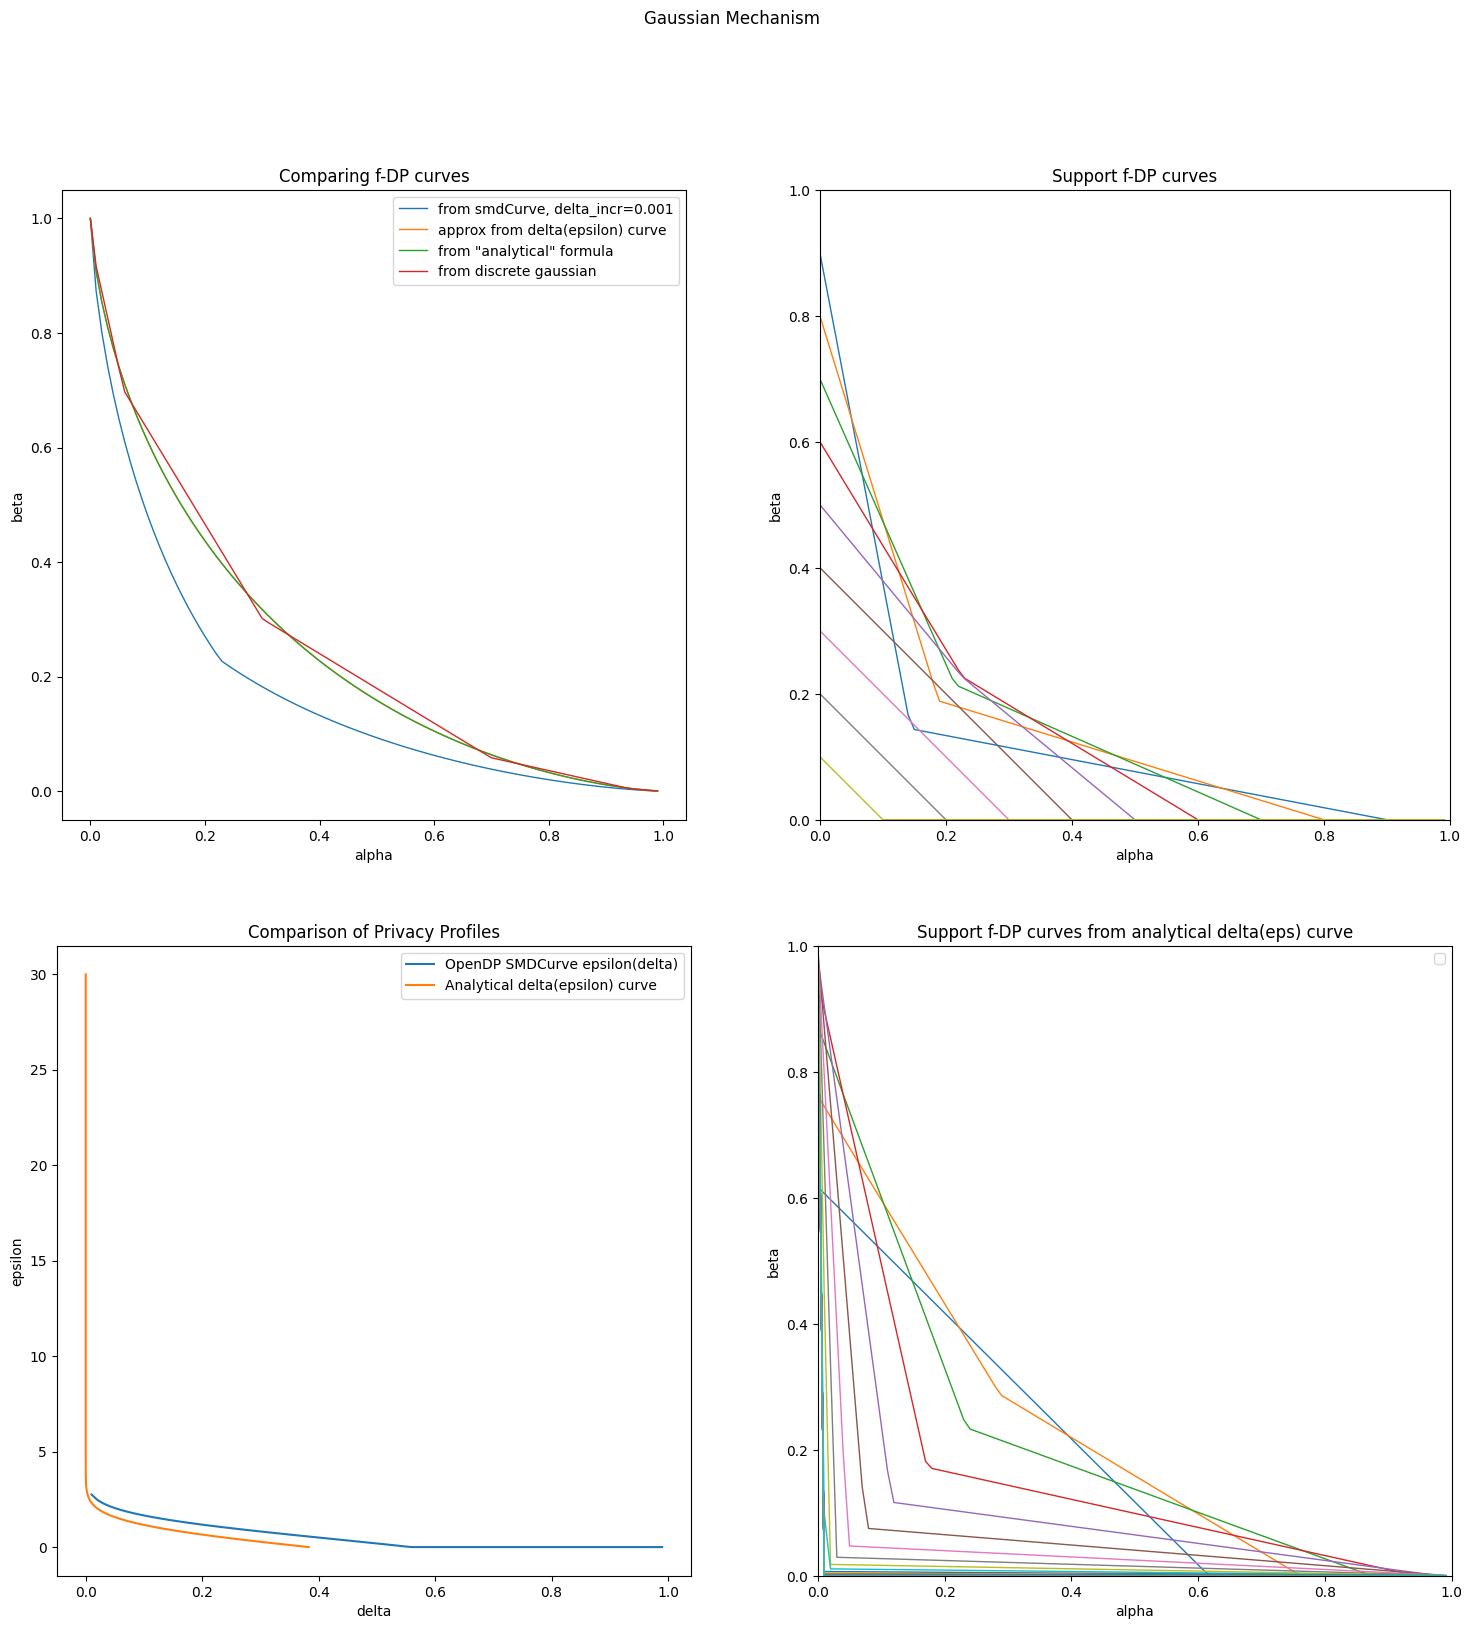

In [38]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
fig.suptitle("Gaussian Mechanism")

# from smdCurve vs analytical
ax1.plot(alphas, betas_gaussian_001, label='from smdCurve, delta_incr=0.001', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_00001, label='from smdCurve, delta_incr=0.00001', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_approx, label='approx from delta(epsilon) curve', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_analytical, label='from \"analytical\" formula', marker='', linewidth=1)
ax1.plot(alphas, betas_gaussian_dg_analytical, label='from discrete gaussian', marker='', linewidth=1)
#ax1.plot(alphas, betas_gaussian_approx_optimization, label="from optimization of dual", marker="", linewidth=1)

ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

# Support lines
for delta in np.arange(0.1, 1, 0.1):
    betas_eps_delta = [support_tradeoff(alpha, gaussian_smd_curve.epsilon(delta), delta) for alpha in alphas]
    ax2.plot(alphas, betas_eps_delta, label=f"f-eps-delta({delta})", marker="", linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Support f-DP curves')
#ax2.legend()
ax2.set_aspect('equal')

ax3.plot(privacy_profile_deltas, privacy_profile_gaussian_approx_epsilons, label="OpenDP SMDCurve epsilon(delta)")
ax3.plot(privacy_profile_gaussian_analytical_deltas, epsilons , label="Analytical delta(epsilon) curve")
ax3.set_xlabel("delta")
ax3.set_ylabel("epsilon")
ax3.set_title("Comparison of Privacy Profiles")
ax3.legend()

for eps in np.arange(0, 30, 0.5):
    betas_delta_eps = [support_tradeoff(alpha, eps, get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps)) for alpha in alphas]
    ax4.plot(alphas, betas_delta_eps, marker="", linewidth=1)
ax4.set_xlabel("alpha")
ax4.set_ylabel("beta")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_title("Support f-DP curves from analytical delta(eps) curve")
ax4.legend()

plt.show()


## Laplace

In [23]:
betas_laplace_001 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=np.arange(0.001, 1, 0.001))(alphas)
betas_laplace_00001 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=np.arange(0.00001, 1, 0.00001))(alphas)
betas_laplace_analytical = [tradeoff_laplace(alpha, laplace_scale, count_sensitivity) for alpha in alphas]

privacy_profile_laplace_approx_epsilons = [laplace_smd_curve.epsilon(delta) for delta in privacy_profile_deltas]
#privacy_profile_gaussian_analytical_deltas = [get_gaussian_privacy_profile(count_sensitivity, gaussian_scale)(eps) for eps in epsilons]

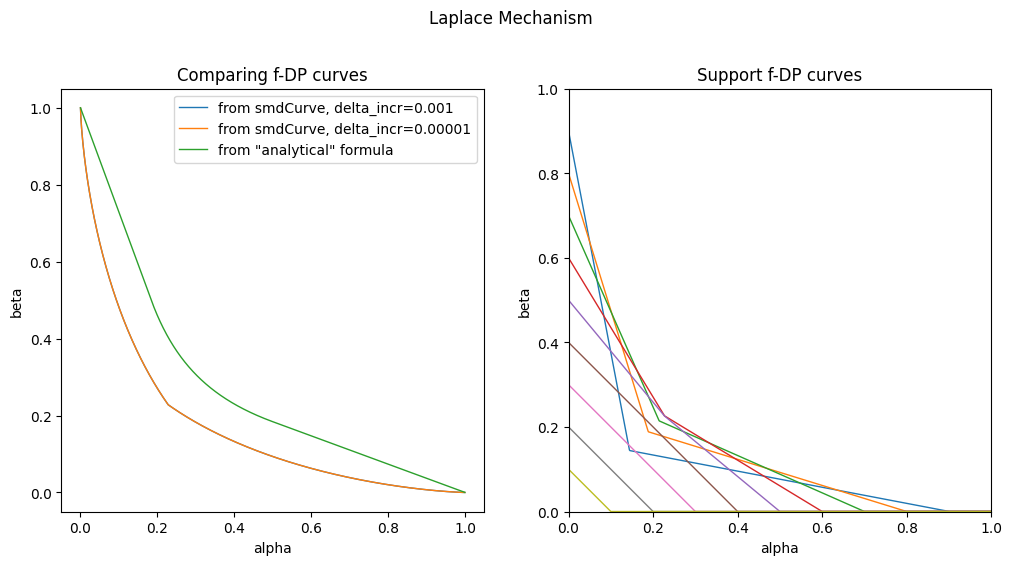

In [25]:
import matplotlib.pyplot as plt

alphas = np.arange(0, 1, 0.001)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Laplace Mechanism")
continuous
# from smdCurve vs analytical
ax1.plot(alphas, betas_laplace_001, label='from smdCurve, delta_incr=0.001', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_00001, label='from smdCurve, delta_incr=0.00001', marker='', linewidth=1)
ax1.plot(alphas, betas_laplace_analytical, label='from \"analytical\" formula', marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.set_title('Comparing f-DP curves')
ax1.legend()
ax1.set_aspect('equal')

# Support lines
for delta in np.arange(0.1, 1, 0.1):
    betas_eps_delta = [support_tradeoff(alpha, laplace_smd_curve.epsilon(delta), delta) for alpha in alphas]
    ax2.plot(alphas, betas_eps_delta, label=f"f-eps-delta({delta})", marker="", linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Support f-DP curves')
#ax2.legend()
ax2.set_aspect('equal')

# TODO shift f-dp curves

plt.show()


TODO next
- posterior = ...
- relative risk = ...

Unused Code

Posterior: $p_{posterior} = \frac{1 - \beta(\alpha)}{(1-p_{prior})\alpha + p_{prior}(1 - \beta(\alpha))}p_{prior}$

In [17]:
from relative_risk import posterior

In [41]:
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
epsilons = np.concatenate((np.arange(0, 0.5, 0.01), np.arange(0.5, 30, 0.01)))

priors = [0.1, 0.2, 0.5, 0.9, 0.99]

tradeoff_approx_gaussian = tradeoffCurve(smdCurveWrapper(gaussian_smd_curve), deltas=deltas)
posteriors_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_approx_gaussian, prior) for alpha in alphas]
    posteriors_gaussian.append(post)

posteriors_analytical_gaussian = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_gaussian(mu=gaussian_mu), prior) for alpha in alphas]
    posteriors_analytical_gaussian.append(post)

tradeoff_discrete_gaussian = tradeoffCurve((lambda e: dg_delta(gaussian_scale**2, e, count_sensitivity, iters=2000)), epsilons=epsilons)
posteriors_discrete_gaussian = []
for prior in priors:
    post = [posterior(alpha, tradeoff_discrete_gaussian, prior) for alpha in alphas]
    posteriors_discrete_gaussian.append(post)

/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:9: RuntimeWarning: invalid value encountered in scalar divide
  posterior = (prior * (1 - beta)) / ((1 - prior)*alpha + prior * (1 - beta))


/tmp/ipykernel_52962/3537118685.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend()


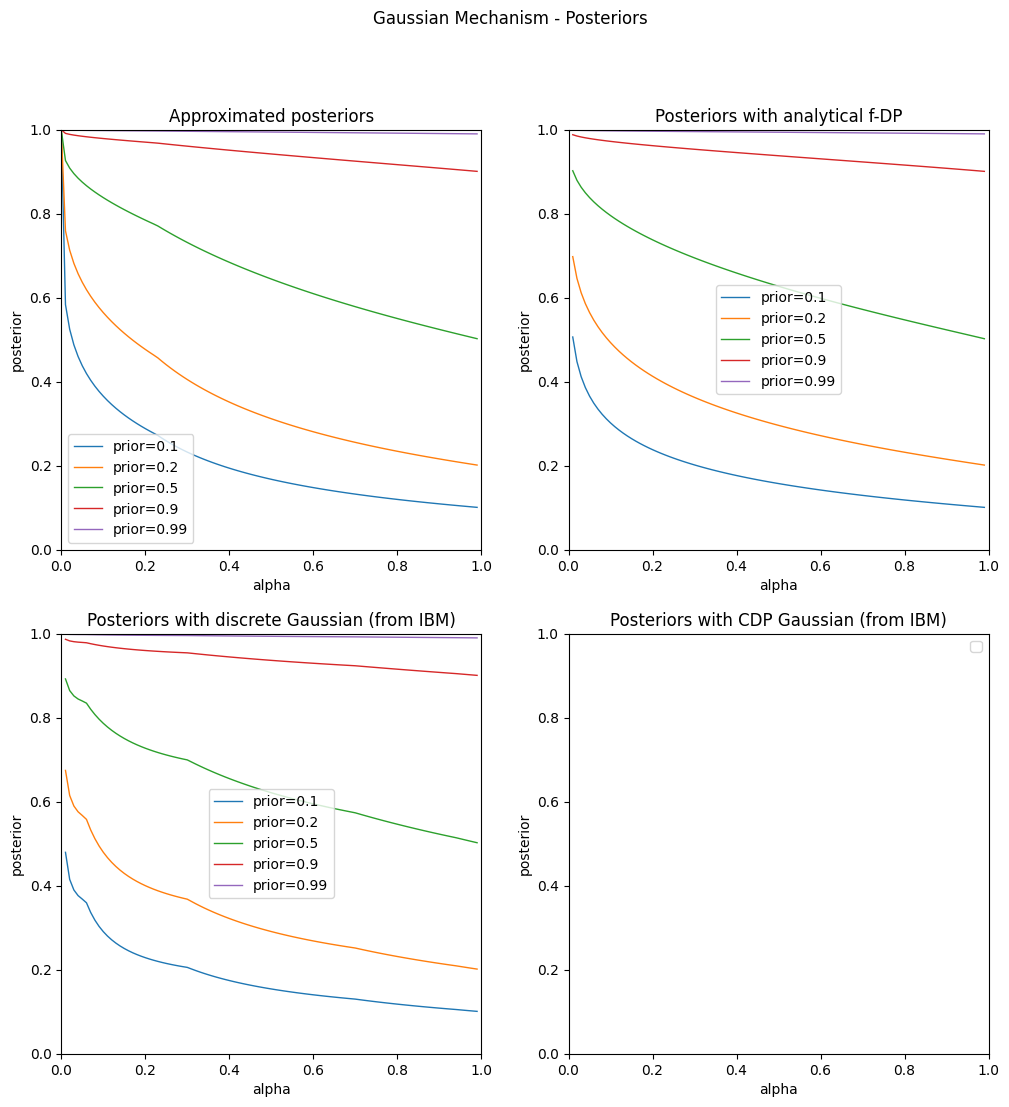

In [44]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Gaussian Mechanism - Posteriors")

ax1.set_title('Approximated posteriors')
for i in range(0, len(posteriors_gaussian)):
    ax1.plot(alphas, posteriors_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')

ax2.set_title('Posteriors with analytical f-DP')
for i in range(0, len(posteriors_gaussian)):
    ax2.plot(alphas, posteriors_analytical_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.set_xlabel('alpha')
ax2.set_ylabel('posterior')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_aspect('equal')

ax3.set_title('Posteriors with discrete Gaussian (from IBM)')
for i in range(0, len(posteriors_gaussian)):
    ax3.plot(alphas, posteriors_discrete_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax3.set_xlabel('alpha')
ax3.set_ylabel('posterior')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_aspect('equal')

ax4.set_title('Posteriors with CDP Gaussian (from IBM)')
for i in range(0, len(posteriors_gaussian)):
    pass
    #ax4.plot(alphas, posteriors_cdp_gaussian[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax4.set_xlabel('alpha')
ax4.set_ylabel('posterior')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_aspect('equal')

plt.show()

In [23]:
alphas = np.arange(0, 1, 0.01)
deltas = np.arange(0.001, 1, 0.001)
priors = [0.1, 0.2, 0.5, 0.9, 0.99]
posteriors_laplace = []

tradeoff_laplace_eps1 = tradeoffCurve(smdCurveWrapper(laplace_smd_curve), deltas=deltas)

for prior in priors:
    post = [posterior(alpha, tradeoff_laplace_eps1, prior) for alpha in alphas]
    posteriors_laplace.append(post)


posteriors_analytical_laplace = []
for prior in priors:
    post = [posterior(alpha, get_tradeoff_laplace(scale=laplace_scale, sensitivity=count_sensitivity), prior) for alpha in alphas]
    posteriors_analytical_laplace.append(post)


/mnt/data/research/opendp/opendp-relative-risk/relative_risk.py:9: RuntimeWarning: invalid value encountered in scalar divide
  posterior = (prior * (1 - beta)) / ((1 - prior)*alpha + prior * (1 - beta))


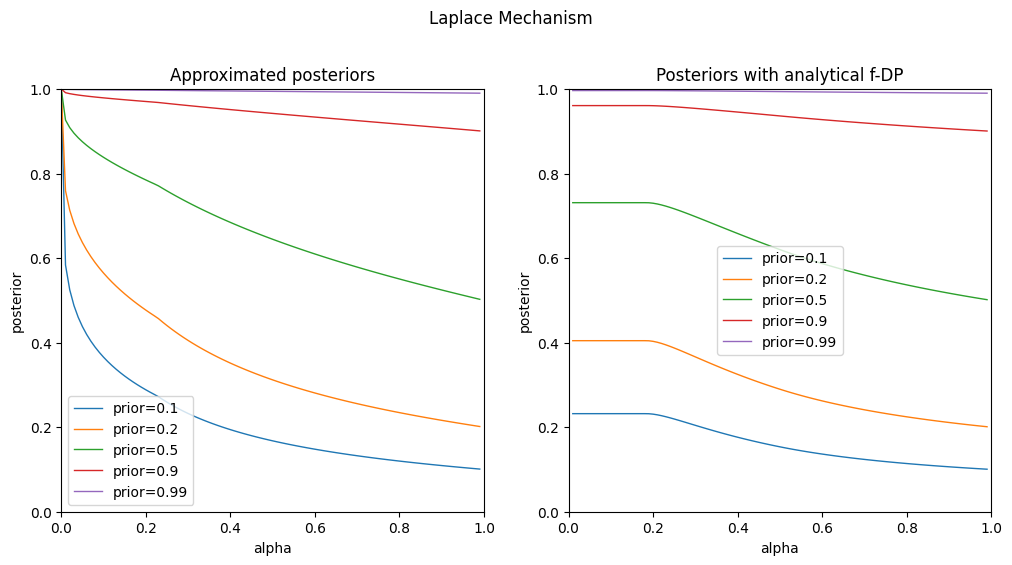

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Laplace Mechanism - Posteriors")

# from smdCurve vs analytical
for i in range(0, len(posteriors_laplace)):
    ax1.plot(alphas, posteriors_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)

ax1.set_xlabel('alpha')
ax1.set_ylabel('posterior')
ax1.set_title('Approximated posteriors')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')

# Support lines

ax2.set_xlabel('alpha')
ax2.set_ylabel('posterior')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_title('Posteriors with analytical f-DP')
for i in range(0, len(posteriors_laplace)):
    ax2.plot(alphas, posteriors_analytical_laplace[i], label=f"prior={priors[i]}", marker='', linewidth=1)
ax2.legend()
ax2.set_aspect('equal')

# TODO shift f-dp curves

plt.show()